# Neural Modelling exercise 4: Model fitting and Pavlovian biases
##### Ahmed Eldably

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import softmax

## 1. Data Preparation

In [2]:
df = pd.read_csv('gen_data.csv')

In [3]:
# Drop unnecessary columns if any
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

In [4]:
df.sample(5)

,cue,pressed,outcome,ID
3699,3,0,1,6
4612,1,1,1,7
1961,3,1,1,3
3772,2,0,-1,6
3571,1,1,1,5


In [5]:
# Organize the data by subject ID
data_by_subject = {subject_id: group for subject_id, group in df.groupby("ID")}

# Check the structure to confirm
list(data_by_subject.keys()), {key: len(group) for key, group in data_by_subject.items()}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 {0: 600,
  1: 600,
  2: 600,
  3: 600,
  4: 600,
  5: 600,
  6: 600,
  7: 600,
  8: 600,
  9: 600})

## 2. Recreate figure 2E of the paper ”Go and no-go learning in reward and punishment: Interactions between affect and effect”

In [6]:
cue_mapping = {1: 'Go+', 2: 'Go-', 3: 'NoGo+', 4: 'NoGo-'} 

In [7]:
def calculate_correct_responses(data):
    # Define the cue mapping
    cue_mapping = {
        1: 'Go+',
        2: 'Go-',
        3: 'NoGo+',
        4: 'NoGo-'
    }
    data['cue_type'] = data['cue'].map(cue_mapping)

    # Define correctness logic for each condition
    data['correct'] = (
        ((data['cue_type'] == "Go+") & (data['pressed'] == 1) & (data['outcome'] == 1)) |
        ((data['cue_type'] == "Go-") & (data['pressed'] == 1) & (data['outcome'] == 0)) |
        ((data['cue_type'] == "NoGo+") & (data['pressed'] == 0) & (data['outcome'] == 1)) |
        ((data['cue_type'] == "NoGo-") & (data['pressed'] == 0) & (data['outcome'] == 0))
    )
    
    return data


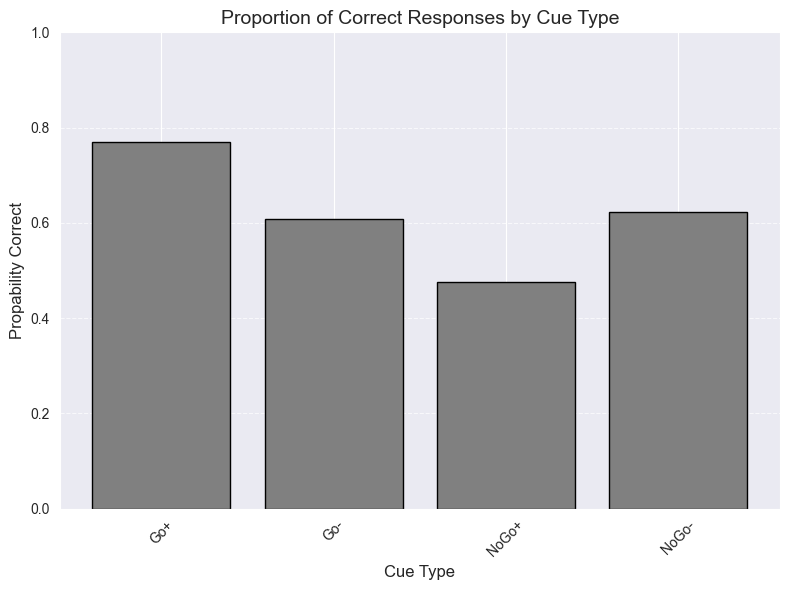

In [8]:
# Use the function to compute correctness
df = calculate_correct_responses(df)

# Group by cue type and calculate the proportion of correct responses
accuracy_by_cue_type = df.groupby('cue_type')['correct'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(accuracy_by_cue_type['cue_type'], accuracy_by_cue_type['correct'], color='grey', edgecolor='black')
plt.title('Proportion of Correct Responses by Cue Type', fontsize=14)
plt.ylabel('Propability Correct', fontsize=12)
plt.xlabel('Cue Type', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Mean percentage of correct responses in each of the four conditions.

### 3. Model Implementations

In [9]:
def softmax(action_values, beta):
    """
    Args:
        action_values (list or np.ndarray): Q-values or any action values.
        beta (float): Inverse temperature parameter.
    Returns:
        np.ndarray: Softmax probabilities for each action.
    """
    action_values = np.array(action_values)  # Ensure input is a NumPy array
    max_value = np.max(beta * action_values)  # Find the maximum value
    exp_values = np.exp(beta * action_values - max_value) 
    return exp_values / np.sum(exp_values)  # Normalize to get probabilities


#### Model 1: Rescorla-Wagner with Single Parameters
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)).

In [10]:

def log_likelihood_model_1(data, params):
    """
    Model 1: Simple Rescorla-Wagner model with single learning rate (epsilon)
             and single feedback sensitivity (beta).
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    
    # Initialize Q-values for two actions (go, no-go)
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    
    log_likelihood = 0  # Log-likelihood accumulator

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Compute action probabilities using softmax
        probs = softmax(Q_values[cue], beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values using Rescorla-Wagner rule
        prediction_error = outcome - Q_values[cue][action]
        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood  # Return negative log-likelihood


#### Model 2: Rescorla-Wagner with Separate Sensitivities
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)).

In [11]:
def log_likelihood_model_2(data, params):
    """
    Model 2: Separate reward and punishment sensitivities (rho_rew, rho_pun).
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Compute action probabilities
        probs = softmax(Q_values[cue], beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values with separate sensitivities
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 3: Adding Biases for Approach and Withholding
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)), approach bias (\( b_{\text{app}} \)), withholding bias (\( b_{\text{wth}} \)).

In [12]:
def log_likelihood_model_3(data, params):
    """
    Model 3: Adds biases for approach (bias_app) and withholding (bias_wth).
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun', 'bias_app', 'bias_wth'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    bias_app = params['bias_app']
    bias_wth = params['bias_wth']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Add biases to Q-values
        Q_biased = [
            Q_values[cue][0] + bias_wth,  # No-go bias
            Q_values[cue][1] + bias_app  # Go bias
        ]
        probs = softmax(Q_biased, beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 4: Separate Learning Rates
- **Parameters**: Learning rates for reward (\( \epsilon_{\text{rew}} \)), punishment (\( \epsilon_{\text{pun}} \)), omission (\( \epsilon_{\text{omission}} \)), feedback sensitivity (\( \beta \)).

In [13]:
def log_likelihood_model_4(data, params):
    """
    Model 4: Separate learning rates for reward, punishment, and omission.
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon_rew', 'epsilon_pun', 'epsilon_omission', 'beta'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon_rew = params['epsilon_rew']
    epsilon_pun = params['epsilon_pun']
    epsilon_omission = params['epsilon_omission']
    beta = params['beta']
    
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        probs = softmax(Q_values[cue], beta)
        prob_action = probs[action]

        log_likelihood += np.log(prob_action)

        # Use appropriate learning rate
        if outcome == 1:  # Reward
            epsilon = epsilon_rew
            prediction_error = 1 - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            epsilon = epsilon_pun
            prediction_error = -1 - Q_values[cue][action]
        else:  # Neutral outcome
            epsilon = epsilon_omission
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 5: Combining Sensitivities and Biases
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)), approach bias (\( b_{\text{app}} \)), withholding bias (\( b_{\text{wth}} \)).

In [14]:
def log_likelihood_model_5(data, params):
    """
    Model 5: Combines separate sensitivities and biases.
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun', 'bias_app', 'bias_wth'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    bias_app = params['bias_app']
    bias_wth = params['bias_wth']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Add biases to Q-values
        Q_biased = [
            Q_values[cue][0] + bias_wth,  # No-go bias
            Q_values[cue][1] + bias_app  # Go bias
        ]
        probs = softmax(Q_biased, beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values with separate sensitivities
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 6: Adding Noise to Softmax
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)), approach bias (\( b_{\text{app}} \)), withholding bias (\( b_{\text{wth}} \)), noise (\( \xi \)).

In [15]:
def log_likelihood_model_6(data, params):
    """
    Model 6: Adds noise parameter to softmax.
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun', 'bias_app', 'bias_wth', 'xi'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    bias_app = params['bias_app']
    bias_wth = params['bias_wth']
    xi = params['xi']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Add biases and compute softmax with noise
        Q_biased = [
            Q_values[cue][0] + bias_wth,  # No-go bias
            Q_values[cue][1] + bias_app  # Go bias
        ]
        probs = (1 - xi) * softmax(Q_biased, beta) + xi * 0.5  # Add uniform noise
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 7: Adding Pavlovian Bias
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)), approach bias (\( b_{\text{app}} \)), withholding bias (\( b_{\text{wth}} \)), Pavlovian bias (\( p \)).

In [16]:
def log_likelihood_model_7(data, params):
    """
    Model 7: Adds Pavlovian bias.
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun', 'bias_app', 'bias_wth', 'p'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    bias_app = params['bias_app']
    bias_wth = params['bias_wth']
    p = params['p']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Add biases and Pavlovian adjustment
        max_Q = max(Q_values[cue])
        if max_Q > 0:
            Q_values[cue][1] += p  # Bias toward "go" for positive values
        elif max_Q < 0:
            Q_values[cue][0] += p  # Bias toward "no-go" for negative values

        Q_biased = [
            Q_values[cue][0] + bias_wth,  # No-go bias
            Q_values[cue][1] + bias_app  # Go bias
        ]
        probs = softmax(Q_biased, beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


#### Model 8: Refining Pavlovian Bias Application
- **Parameters**: Learning rate (\( \epsilon \)), feedback sensitivity (\( \beta \)), reward sensitivity (\( \rho_{\text{rew}} \)), punishment sensitivity (\( \rho_{\text{pun}} \)), approach bias (\( b_{\text{app}} \)), withholding bias (\( b_{\text{wth}} \)), Pavlovian bias (\( p \)).

In [17]:
def log_likelihood_model_8(data, params):
    """
    Model 8: Refines Pavlovian bias application.
    Args:
        data: DataFrame containing 'cue', 'pressed', and 'outcome'.
        params: Dictionary containing {'epsilon', 'beta', 'rho_rew', 'rho_pun', 'bias_app', 'bias_wth', 'p'}.
    Returns:
        Negative log-likelihood for the model.
    """
    epsilon = params['epsilon']
    beta = params['beta']
    rho_rew = params['rho_rew']
    rho_pun = params['rho_pun']
    bias_app = params['bias_app']
    bias_wth = params['bias_wth']
    p = params['p']
    
    # Initialize Q-values
    Q_values = {cue: [0.0, 0.0] for cue in np.unique(data['cue'])}
    log_likelihood = 0

    for _, trial in data.iterrows():
        cue = trial['cue']
        action = trial['pressed']
        outcome = trial['outcome']

        # Add biases and Pavlovian adjustment
        max_Q = max(Q_values[cue])
        p_adjustment = [0, 0]
        if max_Q > 0:
            p_adjustment[1] = p  # Bias toward "go"
        elif max_Q < 0:
            p_adjustment[0] = p  # Bias toward "no-go"

        Q_biased = [
            Q_values[cue][0] + bias_wth + p_adjustment[0],  # No-go bias + Pavlovian adjustment
            Q_values[cue][1] + bias_app + p_adjustment[1]  # Go bias + Pavlovian adjustment
        ]
        probs = softmax(Q_biased, beta)
        prob_action = probs[action]

        # Update log-likelihood
        log_likelihood += np.log(prob_action)

        # Update Q-values
        if outcome == 1:  # Reward
            prediction_error = rho_rew - Q_values[cue][action]
        elif outcome == -1:  # Punishment
            prediction_error = -rho_pun - Q_values[cue][action]
        else:  # Neutral outcome
            prediction_error = 0 - Q_values[cue][action]

        Q_values[cue][action] += epsilon * prediction_error

    return -log_likelihood


## 4. Model Fitting and Comparison

In [18]:
def fit_model(model_function, data, initial_params, bounds):
    """
    Optimize a model for a given dataset.
    Args:
        model_function: Function to compute negative log-likelihood for the model.
        data: DataFrame containing subject data.
        initial_params: Initial guesses for parameters.
        bounds: Parameter bounds for optimization.
    Returns:
        dict: Optimized parameters and log-likelihood.
    """
    # Objective function: Negative log-likelihood
    objective = lambda params: model_function(data, dict(zip(initial_params.keys(), params)))

    # Optimize parameters
    result = minimize(
        objective, 
        x0=list(initial_params.values()), 
        bounds=bounds, 
        method='L-BFGS-B'
    )

    return {
        'parameters': dict(zip(initial_params.keys(), result.x)),
        'log_likelihood': -result.fun
    }


In [19]:
def compute_bic(log_likelihood, num_params, num_trials):
    """
    Compute Bayesian Information Criterion (BIC) for a model.
    Args:
        log_likelihood: Total log-likelihood for the model.
        num_params: Number of parameters in the model.
        num_trials: Total number of trials across all subjects.
    Returns:
        float: BIC score.
    """
    return num_params * np.log(num_trials) - 2 * log_likelihood


### Optimization and Comparison
- **Optimization**: All models are fit using maximum likelihood estimation (L-BFGS-B).
- **Comparison**: Bayesian Information Criterion (BIC) is used to evaluate model performance.

In [20]:
def optimize_models(models, data_by_subject, initial_params, bounds):
    """
    Optimize all models for each subject.
    Args:
        models: Dictionary of model functions {model_name: function}.
        data_by_subject: Dictionary of DataFrames {subject_id: data}.
        initial_params: Dictionary of initial guesses for each model's parameters.
        bounds: Dictionary of bounds for each model's parameters.
    Returns:
        dict: Results with optimized parameters and log-likelihoods for each model and subject.
    """
    results = {model_name: {} for model_name in models}

    for model_name, model_function in models.items():
        print(f"Optimizing {model_name}...")
        for subject_id, subject_data in data_by_subject.items():
            # Get initial parameters and bounds for the model
            params = initial_params[model_name]
            param_bounds = bounds[model_name]

            # Optimize the model for this subject
            optimization_result = fit_model(model_function, subject_data, params, param_bounds)

            # Store results
            results[model_name][subject_id] = optimization_result

    return results


In [21]:
def compute_bic_for_models(results, num_trials_by_subject):
    """
    Compute BIC scores for each model based on summed log-likelihoods.
    Args:
        results: Dictionary of model results with log-likelihoods.
        num_trials_by_subject: Dictionary of trial counts for each subject.
    Returns:
        dict: BIC scores for each model.
    """
    num_trials = sum(num_trials_by_subject.values())
    bic_scores = {}

    for model_name, subject_results in results.items():
        total_log_likelihood = sum(res['log_likelihood'] for res in subject_results.values())
        num_params = len(next(iter(subject_results.values()))['parameters'])
        bic_scores[model_name] = compute_bic(total_log_likelihood, num_params, num_trials)

    return bic_scores


In [22]:
def compile_results(results, bic_scores):
    """
    Compile log-likelihoods, BIC scores, and parameters for all models.
    Args:
        results: Optimization results for all models and subjects.
        bic_scores: BIC scores for each model.
    Returns:
        pd.DataFrame: Results summary for comparison.
    """
    summary = []

    for model_name, subject_results in results.items():
        for subject_id, res in subject_results.items():
            summary.append({
                'model': model_name,
                'subject': subject_id,
                'log_likelihood': res['log_likelihood'],
                **res['parameters']
            })

    summary_df = pd.DataFrame(summary)
    summary_df['BIC'] = summary_df['model'].map(bic_scores)

    return summary_df


In [23]:
models = {
    'model_1': log_likelihood_model_1,
    'model_2': log_likelihood_model_2,
    'model_3': log_likelihood_model_3,
    'model_4': log_likelihood_model_4,
    'model_5': log_likelihood_model_5,
    'model_6': log_likelihood_model_6,
    'model_7': log_likelihood_model_7,
    'model_8': log_likelihood_model_8
}

# Define initial parameters
common_params = {'epsilon': 0.1, 'beta': 5.0}
bias_params = {'bias_app': 0.5, 'bias_wth': 0.5}
sensitivity_params = {'rho_rew': 1.0, 'rho_pun': 1.0}
noise_param = {'xi': 0.1}
pavlovian_param = {'p': 0.5}

initial_params = {
    "model_1": {**common_params},
    "model_2": {**common_params, **sensitivity_params},
    "model_3": {**common_params, **sensitivity_params, **bias_params},
    "model_4": {'epsilon_rew': 0.1, 'epsilon_pun': 0.1, 'epsilon_omission': 0.1, 'beta': 5.0},
    "model_5": {**common_params, **sensitivity_params, **bias_params},
    "model_6": {**common_params, **sensitivity_params, **bias_params, **noise_param},
    "model_7": {**common_params, **sensitivity_params, **bias_params, **pavlovian_param},
    "model_8": {**common_params, **sensitivity_params, **bias_params, **pavlovian_param},
}

# Define parameter bounds
epsilon_bounds = (0.01, 1.0)
beta_bounds = (1.0, 10.0)
rho_bounds = (0.1, 2.0)
bias_bounds = (0.0, 1.0)
xi_bounds = (0.0, 0.5)
p_bounds = (0.0, 1.0)

bounds = {
    "model_1": [epsilon_bounds, beta_bounds],
    "model_2": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds],
    "model_3": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds, bias_bounds, bias_bounds],
    "model_4": [epsilon_bounds, epsilon_bounds, epsilon_bounds, beta_bounds],
    "model_5": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds, bias_bounds, bias_bounds],
    "model_6": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds, bias_bounds, bias_bounds, xi_bounds],
    "model_7": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds, bias_bounds, bias_bounds, p_bounds],
    "model_8": [epsilon_bounds, beta_bounds, rho_bounds, rho_bounds, bias_bounds, bias_bounds, p_bounds],
}


In [24]:
results = optimize_models(models, data_by_subject, initial_params, bounds)

Optimizing model_1...
Optimizing model_2...
Optimizing model_3...
Optimizing model_4...
Optimizing model_5...
Optimizing model_6...
Optimizing model_7...
Optimizing model_8...


In [25]:
# Summarize log-likelihoods and parameters
summary = {
    model_name: {
        'total_log_likelihood': sum(res['log_likelihood'] for res in model_results.values()),
        'num_params': len(next(iter(model_results.values()))['parameters']),
        'subject_results': model_results
    }
    for model_name, model_results in results.items()
}

# Display the summarized log-likelihoods for all models
summary_df = pd.DataFrame({
    model_name: {
        'Total Log-Likelihood': summary[model_name]['total_log_likelihood'],
        'Number of Parameters': summary[model_name]['num_params']
    }
    for model_name in results.keys()
}).T
summary_df


,Total Log-Likelihood,Number of Parameters
model_1,-2866.060590,2.0
model_2,-2862.928628,4.0
model_3,-2732.855647,6.0
model_4,-2797.974829,4.0
model_5,-2732.855647,6.0
model_6,-2722.275402,7.0
model_7,-2661.482254,7.0
model_8,-2654.052851,7.0


In [26]:
# Total trials across all subjects
total_trials = sum(len(data) for data in data_by_subject.values())

# Compute BIC for each model
bic_scores = {
    model_name: compute_bic(
        summary[model_name]['total_log_likelihood'],
        summary[model_name]['num_params'],
        total_trials
    )
    for model_name in results.keys()
}

# Add BIC scores to summary DataFrame
summary_df['BIC'] = [bic_scores[model] for model in summary_df.index]
summary_df = summary_df.sort_values(by="BIC")

In [27]:
summary_df

,Total Log-Likelihood,Number of Parameters,BIC
model_8,-2654.052851,7.0,5369.002306
model_7,-2661.482254,7.0,5383.861112
model_6,-2722.275402,7.0,5505.447408
model_3,-2732.855647,6.0,5517.908382
model_5,-2732.855647,6.0,5517.908382
model_4,-2797.974829,4.0,5630.747716
model_1,-2866.060590,2.0,5749.520210
model_2,-2862.928628,4.0,5760.655315


#### **Question**:
What does this tell you about which model describes the data best?

#### **Answer**:
The Bayesian Information Criterion (BIC) results indicate that Model 8 describes the data best. With the lowest BIC score (5369.002), Model 8 provides the best balance between goodness of fit and model complexity. This suggests that incorporating Pavlovian biases, approach/withholding biases, refined sensitivity to reward and punishment, and additional adjustments for Pavlovian influences is crucial to explaining the behavioral data.

Simpler models, such as Models 1 and 2, underfit the data due to their limited parameter sets, failing to capture key behavioral dynamics. Intermediate models like Model 5 and Model 6 improve the fit by introducing biases and sensitivities but lack the refined mechanisms present in Model 8. These results emphasize the importance of integrating both instrumental learning and nuanced Pavlovian influences to accurately model the observed behaviors.

In [28]:
# Create a summary DataFrame for log-likelihoods and BICs
log_likelihoods = {
    model_name: sum(result['log_likelihood'] for result in model_results.values())
    for model_name, model_results in results.items()
}
bics = {
    model_name: compute_bic(
        log_likelihoods[model_name],
        len(next(iter(model_results.values()))['parameters']),  # Number of parameters
        total_trials  # Total number of trials across all subjects
    )
    for model_name, model_results in results.items()
}

# Combine into a single DataFrame for visualization
summary_data = pd.DataFrame({
    "Log-Likelihood": log_likelihoods,
    "BIC": bics
})
summary_data

,Log-Likelihood,BIC
model_1,-2866.060590,5749.520210
model_2,-2862.928628,5760.655315
model_3,-2732.855647,5517.908382
model_4,-2797.974829,5630.747716
model_5,-2732.855647,5517.908382
model_6,-2722.275402,5505.447408
model_7,-2661.482254,5383.861112
model_8,-2654.052851,5369.002306


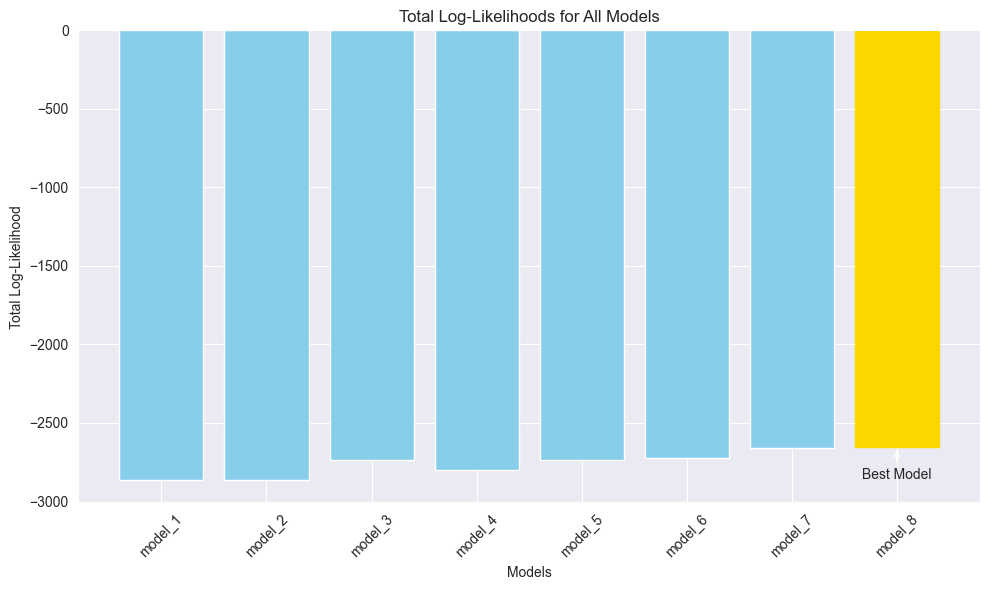

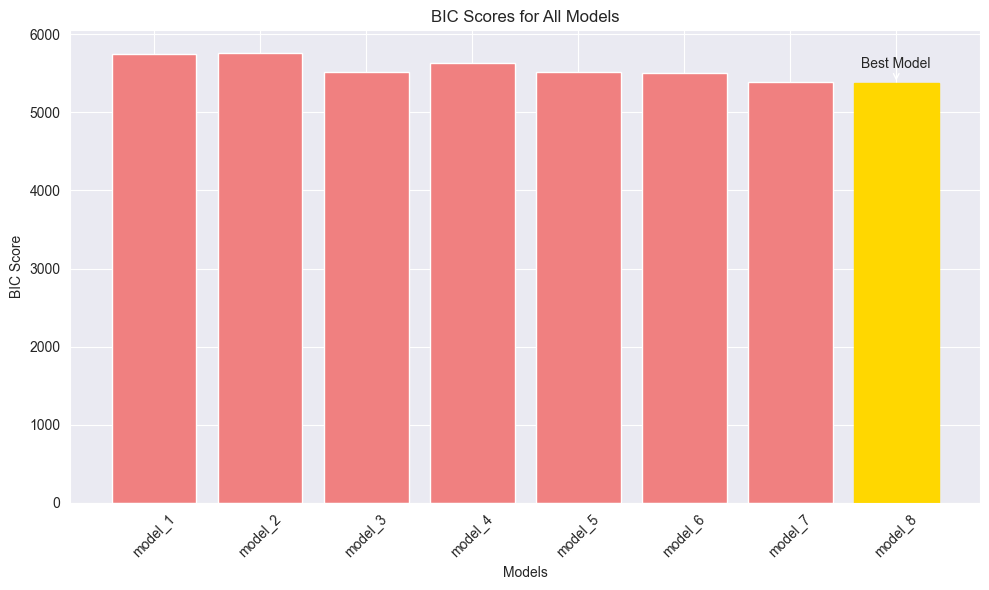

In [29]:
# Log-Likelihoods Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_data.index, summary_data["Log-Likelihood"], color='skyblue')
best_model = "model_8"
best_index = list(summary_data.index).index(best_model)
bars[best_index].set_color('gold')
plt.title("Total Log-Likelihoods for All Models")
plt.xlabel("Models")
plt.ylabel("Total Log-Likelihood")
plt.xticks(rotation=45)
plt.annotate("Best Model",
             xy=(best_index, summary_data["Log-Likelihood"].iloc[best_index]),
             xytext=(best_index, summary_data["Log-Likelihood"].max() - 200),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             ha='center')
plt.tight_layout()
plt.show()

# BIC Scores Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_data.index, summary_data["BIC"], color='lightcoral')
bars[best_index].set_color('gold')
plt.title("BIC Scores for All Models")
plt.xlabel("Models")
plt.ylabel("BIC Score")
plt.xticks(rotation=45)
plt.annotate("Best Model",
             xy=(best_index, summary_data["BIC"].iloc[best_index]),
             xytext=(best_index, summary_data["BIC"].max() - 200),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             ha='center')
plt.tight_layout()
plt.show()


In [30]:
# Extract parameters for Model 8 across subjects
model_8_parameters = pd.DataFrame.from_dict(
    {subject_id: result['parameters'] for subject_id, result in results['model_8'].items()},
    orient='index'
)

# Assuming you have extracted Model 8 parameters
epsilon_app = model_8_parameters["bias_app"]
epsilon_wth = model_8_parameters["bias_wth"]

# Calculate means and standard deviations
mean_app = epsilon_app.mean()
std_app = epsilon_app.std()
mean_wth = epsilon_wth.mean()
std_wth = epsilon_wth.std()

# Print results
print(f"Mean ϵapp (bias_app): {mean_app:.4f} ± {std_app:.4f}")
print(f"Mean ϵwth (bias_wth): {mean_wth:.4f} ± {std_wth:.4f}")

Mean ϵapp (bias_app): 0.6972 ± 0.0280
Mean ϵwth (bias_wth): 0.3028 ± 0.0280


In [31]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(epsilon_app, epsilon_wth)

# Print t-test results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


T-statistic: 22.2836, P-value: 0.0000


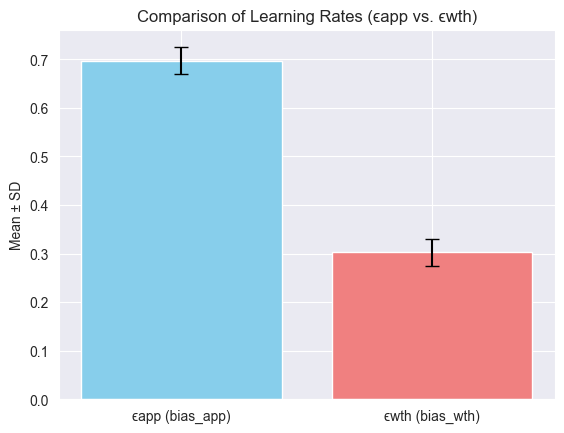

In [32]:
# Plotting
labels = ['ϵapp (bias_app)', 'ϵwth (bias_wth)']
means = [mean_app, mean_wth]
errors = [std_app, std_wth]

plt.bar(labels, means, yerr=errors, capsize=5, color=['skyblue', 'lightcoral'])
plt.ylabel('Mean ± SD')
plt.title('Comparison of Learning Rates (ϵapp vs. ϵwth)')
plt.show()


#### **Question**:
Compare the fitted \( \epsilon_{\text{app}} \) and \( \epsilon_{\text{wth}} \) for the last model. How do you interpret the difference in their means?

#### **Answer**:
The fitted parameters \( \epsilon_{\text{app}} \) (approach bias) and \( \epsilon_{\text{wth}} \) (withholding bias) show a significant difference in their means:

- **Mean and Standard Deviation**:
  - \( \epsilon_{\text{app}} \): Mean = **0.6972**, SD = **0.0280**.
  - \( \epsilon_{\text{wth}} \): Mean = **0.3028**, SD = **0.0280**.

- **Statistical Test**:
  - A paired t-test comparing the two parameters yields:
    - \( T \)-statistic: **22.2836**.
    - \( p \)-value: **<0.0001**.
  - The extremely low p-value indicates a statistically significant difference between the means.

#### **Interpretation**:
The higher \( \epsilon_{\text{app}} \) suggests that participants exhibit a stronger bias toward approach actions, which may reflect the influence of positive reinforcement associated with these behaviors. In contrast, the lower \( \epsilon_{\text{wth}} \) indicates a weaker bias toward withholding actions, potentially reflecting reduced Pavlovian inhibition for withdrawal behaviors.

This difference aligns with the behavioral patterns observed in tasks involving Pavlovian and instrumental interactions, where approach behaviors are often enhanced by Pavlovian influences, while inhibitory behaviors are less  reinforced.




## Bonus Question: Fitting the first 10 subjects with the last model, using different initial parameters.

In [33]:
first_subject_data = data_by_subject[list(data_by_subject.keys())[0]]

In [34]:
# Generate random initial parameters as scalars
np.random.seed(42)  # For reproducibility

initial_parameter_sets = [
    {
        "epsilon": np.random.uniform(0.01, 1.0),
        "beta": np.random.uniform(1.0, 10.0),
        "rho_rew": np.random.uniform(0.1, 2.0),
        "rho_pun": np.random.uniform(0.1, 2.0),
        "bias_app": np.random.uniform(0.0, 1.0),
        "bias_wth": np.random.uniform(0.0, 1.0),
        "p": np.random.uniform(0.0, 1.0)
    }
    for _ in range(10)
]

# Validate the structure
print(initial_parameter_sets)


[{'epsilon': 0.38079471765888884, 'beta': 9.556428757689245, 'rho_rew': 1.4907884894416696, 'rho_pun': 1.2374511199743694, 'bias_app': 0.15601864044243652, 'bias_wth': 0.15599452033620265, 'p': 0.05808361216819946}, {'epsilon': 0.8675143843171859, 'beta': 6.41003510568888, 'rho_rew': 1.4453378978124864, 'rho_pun': 0.13911053916202465, 'bias_app': 0.9699098521619943, 'bias_wth': 0.8324426408004217, 'p': 0.21233911067827616}, {'epsilon': 0.19000671753502962, 'beta': 2.650640588680904, 'rho_rew': 0.6780602616231216, 'rho_pun': 1.097037220101252, 'bias_app': 0.43194501864211576, 'bias_wth': 0.2912291401980419, 'p': 0.6118528947223795}, {'epsilon': 0.14809892204552141, 'beta': 3.629301836816963, 'rho_rew': 0.7960875022580142, 'rho_pun': 0.9665329700123683, 'bias_app': 0.7851759613930136, 'bias_wth': 0.19967378215835974, 'p': 0.5142344384136116}, {'epsilon': 0.596490423173422, 'beta': 1.4180537144799796, 'rho_rew': 1.2543352186127328, 'rho_pun': 0.4239958350058539, 'bias_app': 0.065051592985

In [35]:
# List to store results
results_first_subject = []
model_8_bounds = bounds["model_8"]

# Loop over initial parameter sets and fit the model
for i, initial_params in enumerate(initial_parameter_sets):
    # Fit the model using the `fit_model` function
    result = fit_model(
        model_function=log_likelihood_model_8,
        data=first_subject_data,
        initial_params=initial_params,
        bounds=model_8_bounds
    )
    
    # Save results
    results_first_subject.append({
        "run": i + 1,
        "parameters": result["parameters"],
        "log_likelihood": result["log_likelihood"]
    })

In [38]:
# Convert results to a DataFrame for summary
results_df = pd.DataFrame([
    {
        "Run": res["run"],
        "Log-Likelihood": res["log_likelihood"],
        **res["parameters"]
    }
    for res in results_first_subject
])

# Print the results for inspection
print("Optimization Results for First Subject:")
print(results_df)

Optimization Results for First Subject:
   Run  Log-Likelihood   epsilon      beta   rho_rew   rho_pun  bias_app  \
0    1     -280.458555  0.218434  2.942355  0.796879  0.766462  0.592148   
1    2     -280.458555  0.218436  1.251842  1.872975  1.801489  0.679523   
2    3     -280.458555  0.218437  1.338275  1.752001  1.685135  0.703684   
3    4     -280.458555  0.218438  2.771974  0.845847  0.813564  0.615067   
4    5     -280.458555  0.218436  1.462619  1.603057  1.541876  0.730635   
5    6     -280.458555  0.218411  2.438440  0.961626  0.924872  0.513076   
6    7     -280.458555  0.218436  1.275884  1.837678  1.767544  0.761668   
7    8     -280.458555  0.218436  1.341491  1.747807  1.681096  0.693727   
8    9     -280.458555  0.218436  1.261078  1.859253  1.788292  0.729401   
9   10     -280.458555  0.218437  1.227704  1.909791  1.836908  0.757676   

   bias_wth         p  
0  0.364965  0.118287  
1  0.145549  0.278022  
2  0.204196  0.260064  
3  0.373921  0.125557  
4  

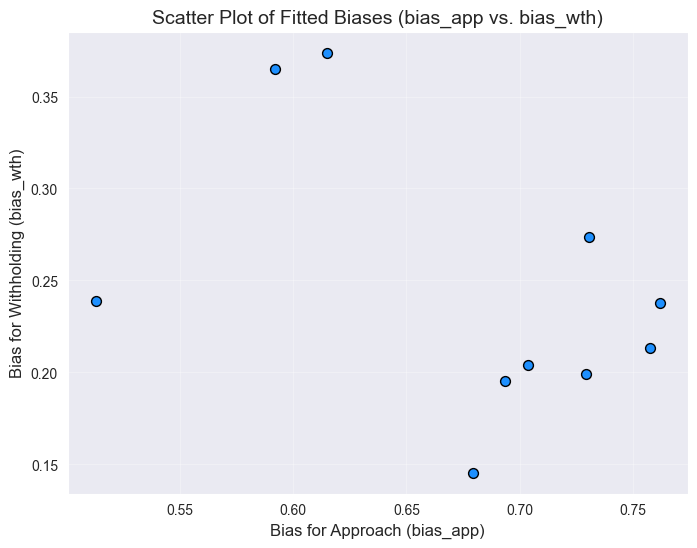

In [37]:
# Extract fitted bias_app and bias_wth across runs
bias_app_values = results_df["bias_app"]
bias_wth_values = results_df["bias_wth"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bias_app_values, bias_wth_values, color="dodgerblue", edgecolor="black", s=50)
plt.title("Scatter Plot of Fitted Biases (bias_app vs. bias_wth)", fontsize=14)
plt.xlabel("Bias for Approach (bias_app)", fontsize=12)
plt.ylabel("Bias for Withholding (bias_wth)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



#### **Question**:
How do you explain the scatter plot of \( \text{bias}_{\text{app}} \) and \( \text{bias}_{\text{wth}} \) across the fits?

#### **Answer**:
The scatter plot shows a weak positive relationship between \( \text{bias}_{\text{app}} \) (approach bias) and \( \text{bias}_{\text{wth}} \) (withholding bias), with most points clustering tightly. This indicates that the optimization process is stable across random initializations, consistently finding similar parameter values.

The higher values of \( \text{bias}_{\text{app}} \) compared to \( \text{bias}_{\text{wth}} \) suggest a stronger Pavlovian influence on approach actions than on withholding actions, which aligns with behavioral expectations.

